给高loss的数据加权,提高这些数据被采样中的概率.

为了缓解过拟合,降低这些数据的lr,这里以削减loss的方式实现.

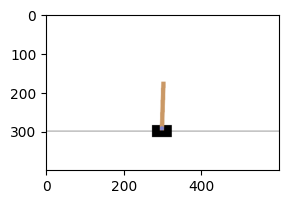

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch

#定义模型,评估状态下每个动作的价值
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

#延迟更新的模型,用于计算target
model_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

#复制参数
model_delay.load_state_dict(model.state_dict())

model, model_delay

(Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
 ))

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

C:\Users\18646\anaconda3\envs\cs260r1\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-991.0

In [4]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []
        self.prob = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            data = play()[0]
            self.pool.extend(data)
            #维护概率表
            self.prob.extend([1.0] * len(data))

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]
        self.prob = self.prob[-2_0000:]

    #获取一批数据样本
    def sample(self):
        idx = torch.FloatTensor(self.prob).clamp(0.1, 1.0).multinomial(
            num_samples=64, replacement=False)

        data = [self.pool[i] for i in idx]

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return idx, state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

C:\Users\18646\AppData\Local\Temp\ipykernel_10032\919455838.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(207,
 (array([ 0.04968573, -0.0413436 ,  0.00053954,  0.02546039], dtype=float32),
  0,
  1.0,
  array([ 0.04885886, -0.23647328,  0.00104875,  0.3183135 ], dtype=float32),
  False))

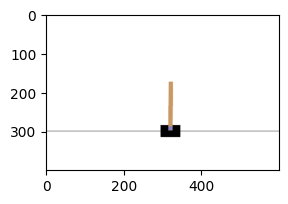

200.0

In [6]:
play(True)[-1]

In [10]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss(reduction='none')

    #共更新N轮数据
    for epoch in range(1000):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            idx, state, action, reward, next_state, over = pool.sample()

            #计算value
            value = model(state).gather(dim=1, index=action)

            #计算target
            with torch.no_grad():
                target = model_delay(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            print(target.shape,'old')
            print(reward.shape,'old1')
            target = target * 0.99 * (1 - over) + reward
            print(target.shape)

            #根据概率缩放loss
            r = torch.FloatTensor([pool.prob[i] for i in idx])
            r = (1 - r).clamp(0.1, 1.0).reshape(-1, 1)

            loss = loss_fn(value, target)
            (loss * r).mean(0).backward()
            optimizer.step()
            optimizer.zero_grad()

            #根据loss调整数据权重
            for i, j in zip(idx.tolist(),
                            loss.abs().sigmoid().flatten().tolist()):
                pool.prob[i] = j

        #复制参数
        if (epoch + 1) % 5 == 0:
            model_delay.load_state_dict(model.state_dict())

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), pool.prob[::5000], test_result)


train()

torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size

torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size

torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size

torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size

torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size

torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size

torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size

torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size

torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size([64, 1]) old1
torch.Size([64, 1])
torch.Size([64, 1]) old
torch.Size

KeyboardInterrupt: 